# FFDI analysis


1. Read some data, make some plots 
   

In [1]:
## Imports
import xarray as xr
import numpy as np
import pandas as pd

import time
import importlib
import dask

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

## Put us in the right repo for local relative pathing
import os
__repo__="/g/data/en0/jwg574/repos/simple_fire_metric//"
os.chdir(__repo__)

import fio,plotting

In [2]:
## Dask
from dask.distributed import Client
client = Client()
#display(client.proxy)
print(client.dashboard_link)

/proxy/8787/status


In [3]:
## SETTINGS ##

dir_scratch = '/scratch/en0/jwg574/'


latrange=[-48,-9]
lonrange=[111,155]

vars_needed_for_ffdi = ['u10','v10','d2m','t2m']

In [7]:
importlib.reload(fio)

ds_daily = fio.ERA5_read_month(vars_needed_for_ffdi,'2019-12')
ds_daily = fio.select_australia(ds_daily)
ds_daily = fio.calc_ffdi(ds_daily)


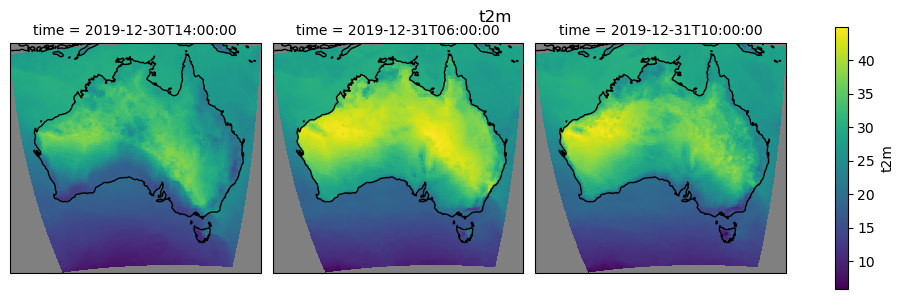

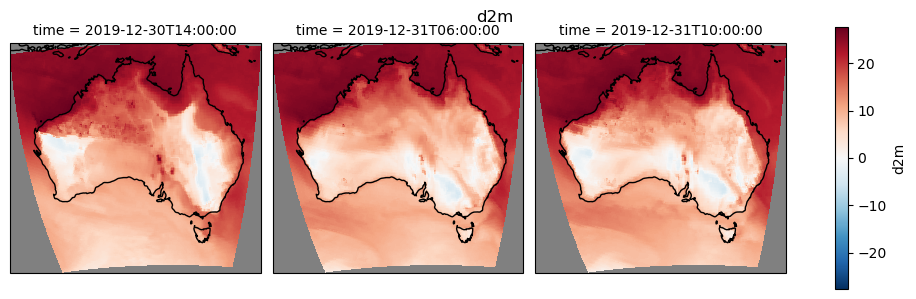

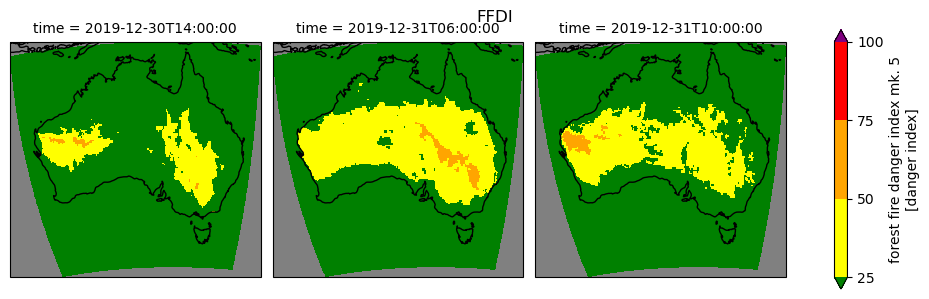

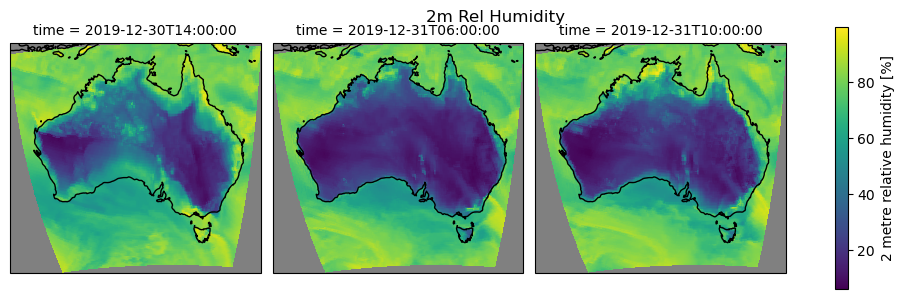

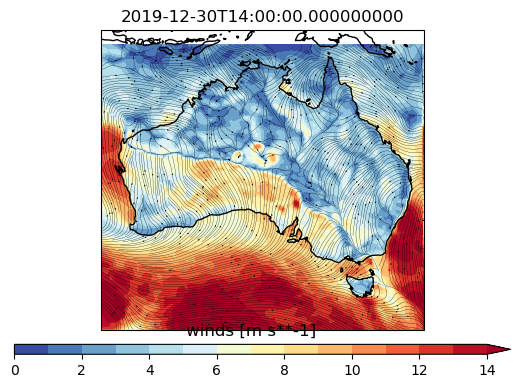

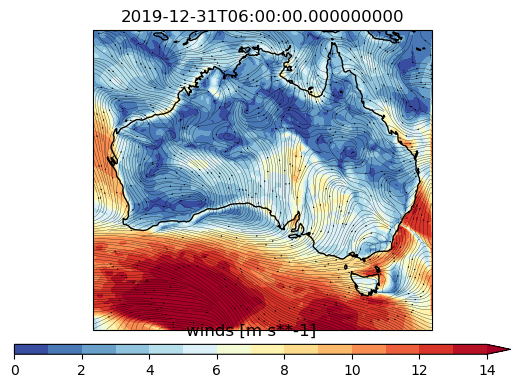

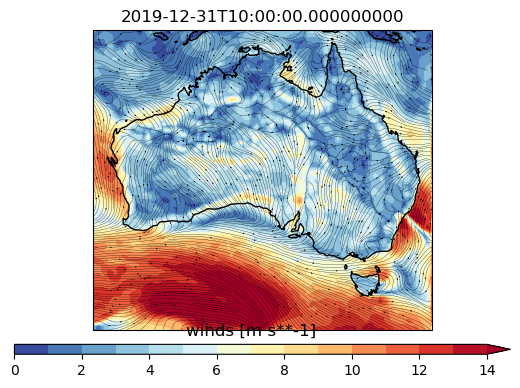

In [13]:
importlib.reload(plotting)

itimes=[-34,-18,-14]

for var in ['t2m','d2m']:
    # celcius instead of kelvin
    plotting.plot_quick(ds_daily[var]-273.15,itimes=itimes,)
    plt.suptitle(var);
    plt.show()
plotting.plot_ffdi(ds_daily['FFDI'],itimes=itimes)
plt.suptitle('FFDI')
plt.show()
plotting.plot_quick(ds_daily['rh2m'],itimes=itimes)
plt.suptitle('2m Rel Humidity')
plt.show()
plotting.plot_winds(ds_daily,itimes=itimes)
    


## Stats over time

- maximum daily values of FFDI and DWI_V are saved
- plots are created in script: __plot_diff2000.qsub__
    - can just run qsub plot_diff2000.qsub
    - images pooped into figures/diff2000
- Examine FFDI excedences
- Examine diff pre/post 2000 in ERA5



In [4]:
## Plots created using script: plot_diff2000.qsub

from glob import glob
from matplotlib.image import imread

plot_names = glob('figures/diff2000/*.png')
plot_names.sort()
most_interest_plots = [plot_names[i] for i in [0,1,2, 7,10,13, 14,17,18,]]

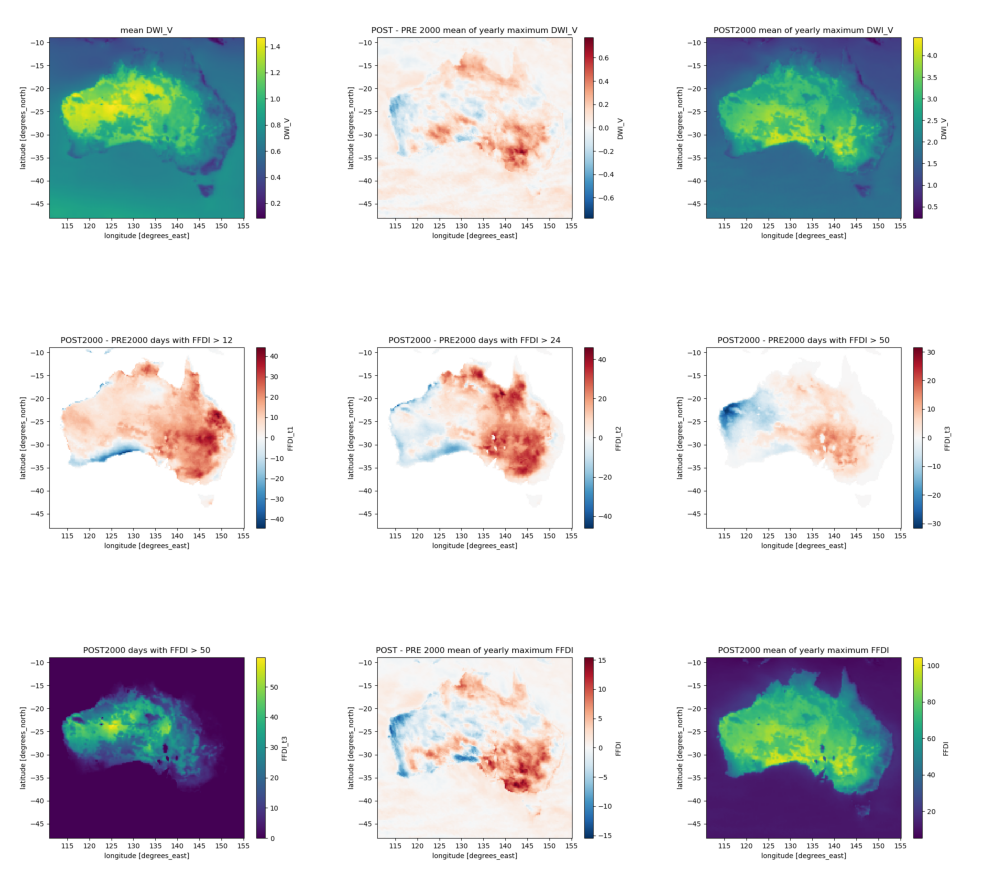

In [6]:
#for f in plot_names:
fig, axes = plt.subplots(3,3,figsize=[10,10])

for i,f in enumerate(most_interest_plots):
    ax = axes.flatten()[i]
    plt.sca(ax)
    plt.imshow(imread(f))
    plt.axis('off')
    #display(Image(f,width=200))
    #plt.title(f)
    #plt.show()
plt.tight_layout()
plt.show()


# Dowdy emulations

2. First plot:
    - 90th, 95th, 99th,
    - return periods:
        - 1 year returnn period is 99.7th percentie
            - $
10- 2 (1/365.2*5)10= 5 99$
            - 5 yr: .7
    - Additional: difference between 2030s, 2040s, ... in both SSPs in BARPA


In [14]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature


In [4]:
importlib.reload(fio)

ds = fio.ERA5_read_dailymaximums()

/g/data/en0/jwg574/repos/extra_pip_libs/lib/python3.9/site-packages/ecmwflibs/__init__.py:83: UserWarning: No module named 'ecmwflibs._ecmwflibs'
  warnings.warn(str(e))


In [16]:
print(ds.FFDI.shape)


(24472, 157, 177)


In [5]:
percentiles = [0.9,.95,.99]
returns = [1-(1/(P*365.2425)) for P in [1,5,10]]
print(percentiles + returns)
qs = percentiles + returns

[0.9, 0.95, 0.99, 0.9972620929930115, 0.9994524185986023, 0.9997262092993011]


In [6]:
%%time
#ds # 24472 days, 157 lats, 177 lons
## Percentiles
FORCE=False
url_era_quantiles = "/g/data/en0/jwg574/repos/climate_fire/data/ERA5_percentiles.nc"
if os.path.isfile(url_era_quantiles) and not FORCE:
    print("INFO: Reading:",url_era_quantiles)
    era5_percentiles = xr.open_dataset(url_era_quantiles)
else:

    print("INFO: calculating ffdi percentiles")
    ffdi_percentiles = ds.FFDI.quantile(qs,dim='time')
    print("INFO: calculating DWI_V percentiles")
    dwi_percentiles = ds.DWI_V.quantile(qs,dim='time')
    
    print("INFO: Writing:",url_era_quantiles)
    era5_percentiles = xr.merge([ffdi_percentiles,dwi_percentiles])
    era5_percentiles.to_netcdf(url_era_quantiles)


INFO: Reading: /g/data/en0/jwg574/repos/climate_fire/data/ERA5_percentiles.nc
CPU times: user 17.8 ms, sys: 4.26 ms, total: 22.1 ms
Wall time: 54.6 ms


In [24]:
era5_percentiles

<xarray.Dataset>
Dimensions:    (longitude: 177, latitude: 157, quantile: 6)
Coordinates:
  * longitude  (longitude) float32 111.0 111.2 111.5 111.8 ... 154.5 154.8 155.0
  * latitude   (latitude) float32 -9.0 -9.25 -9.5 -9.75 ... -47.5 -47.75 -48.0
  * quantile   (quantile) float64 0.9 0.95 0.99 0.9973 0.9995 0.9997
Data variables:
    FFDI       (quantile, latitude, longitude) float64 ...
    DWI_V      (quantile, latitude, longitude) float64 ...

In [18]:

#ffdi_percentiles.where(ausmask).plot(row='quantile')
#ffdi_percentiles.where(ausmask).plot.contour(levels=[12,24,50,60,70,80,90,100],row='quantile',add_colorbar=False,colors='k')

def dowdy_1(da,
            levels = [25,50,75,100],
            colors = ['yellow','orange','red','purple'],
            vmin=10,
            vmax=105,
            qs=qs,
           ):
    """ da [quantiles,lats,lons] """
    ausmask = fio.get_landmask(da[0])
    crs = ccrs.PlateCarree(central_longitude=140)
    trans = ccrs.PlateCarree()
    fig,axes = plt.subplots(3,2,figsize=[12,9], subplot_kw={'projection': crs})
    for i,q in enumerate(qs):
        da_i = da.where(ausmask)[i]

        # progress down columns
        ax = axes.T.flatten()[i]
        plt.sca(ax)
        cm1 = plt.pcolormesh(da_i.longitude,da_i.latitude,da_i,vmin=vmin, vmax=vmax, transform=trans)
        cm2 = plt.contour(da_i.longitude,da_i.latitude,da_i, levels=levels, colors=colors, transform=trans)
        ax.coastlines()
        
        plt.title('quantile=%.2f'%q)
        if i>2:
            plt.title('return period = %d'%([1,5,10][i-3]))
        #plt.show()
    plt.tight_layout()
    # add axis for colorbar
    ax = fig.add_axes([.48,.3,.04,.4]) # [xmin,ymin,dx,dy]
    plt.sca(ax)
    # add colorbar
    cb = plt.colorbar(cm1, pad=0.01, cax=ax)
    for cline,color in zip(levels,colors):
        cb.ax.plot([0, 1], [cline]*2, color)
    return


INFO: Figure saved:  figures/dowdy1_ffdi.png
INFO: Figure saved:  figures/dowdy1_dwi.png


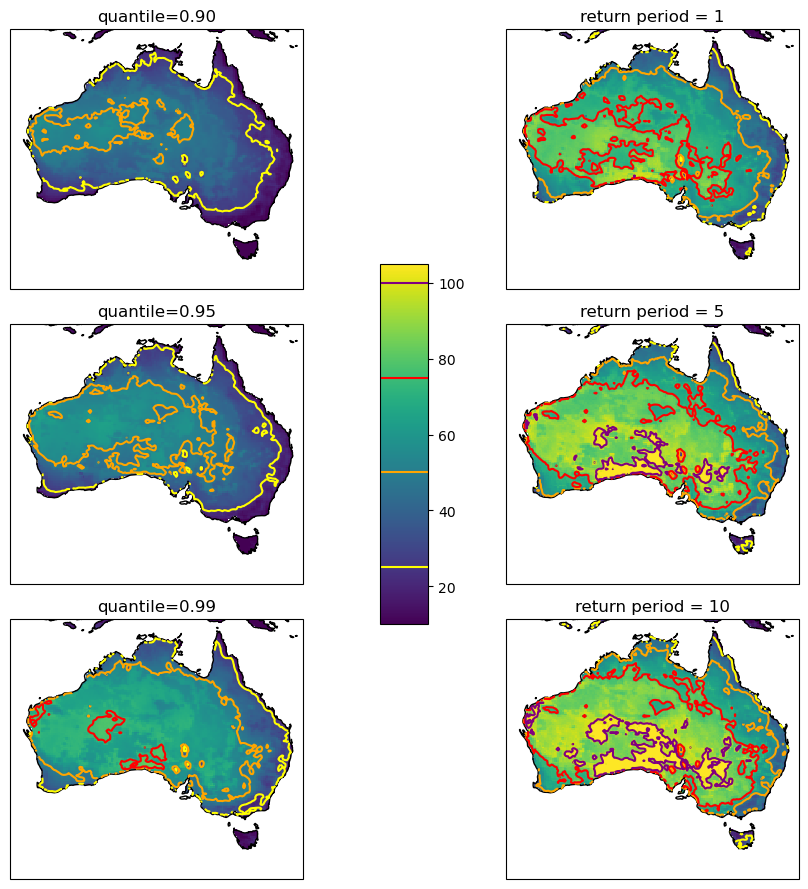

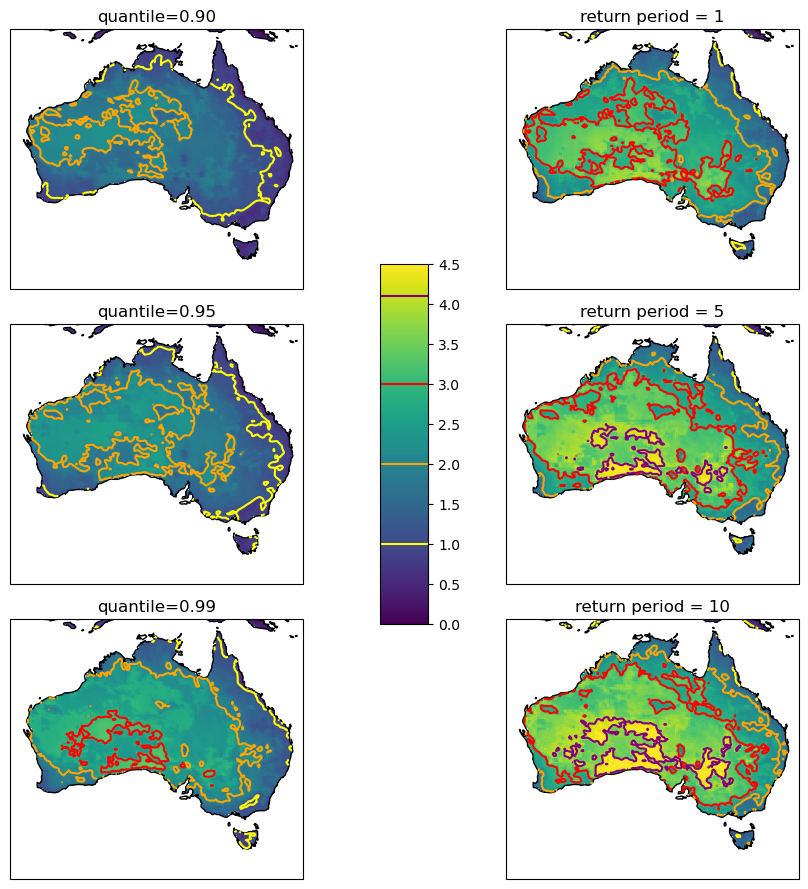

In [37]:
dowdy_1(era5_percentiles.FFDI)
fname = "figures/dowdy1_ffdi.png"
print("INFO: Figure saved: ",fname)
plt.savefig(fname)
dowdy_1(era5_percentiles.DWI_V,
        levels=[1,2,3,4.1],
        colors=['yellow','orange','red','purple'],
       vmin=0,vmax=4.5,)
fname = "figures/dowdy1_dwi.png"
print("INFO: Figure saved: ",fname)
plt.savefig(fname)

# SAME but using yearly maximums (not daily)

In [6]:
importlib.reload(fio)

<module 'fio' from '/g/data/en0/jwg574/repos/climate_fire/fio.py'>

In [7]:
qs_yearly = [0.0,0.5,1.0,0.0, 0.8, 0.9]

In [20]:
ds_yearly=fio.ERA5_read_yearlymaximums()
era5_percentiles_yearly = ds_yearly.quantile(qs_yearly,dim='time')


INFO: Figure saved:  figures/dowdy1_ffdi_yearly.png
INFO: Figure saved:  figures/dowdy1_dwi_yearly.png


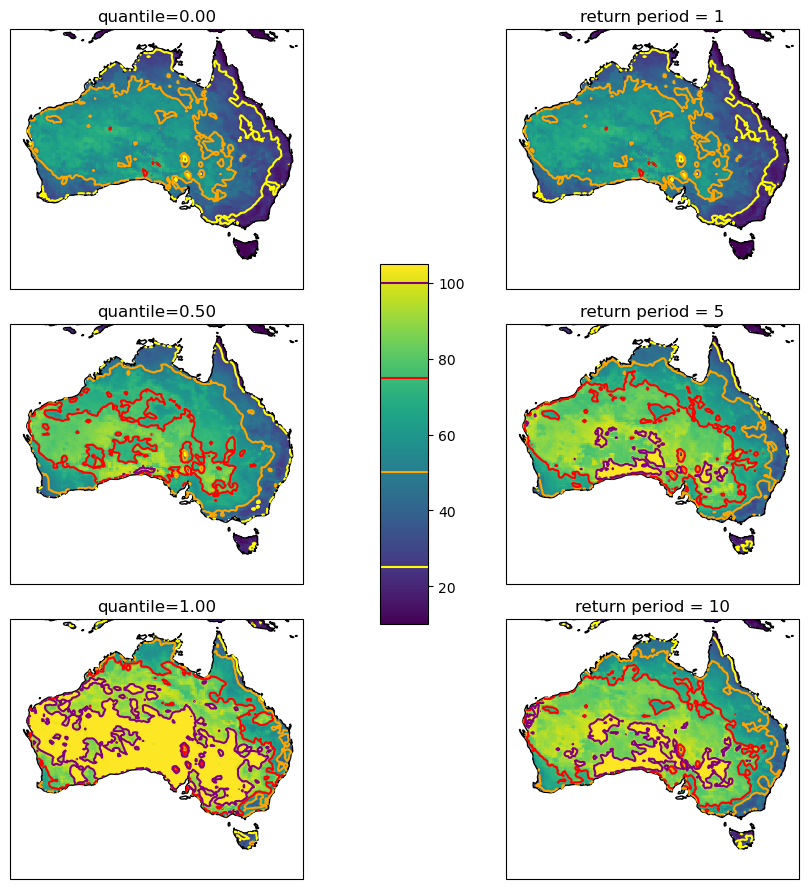

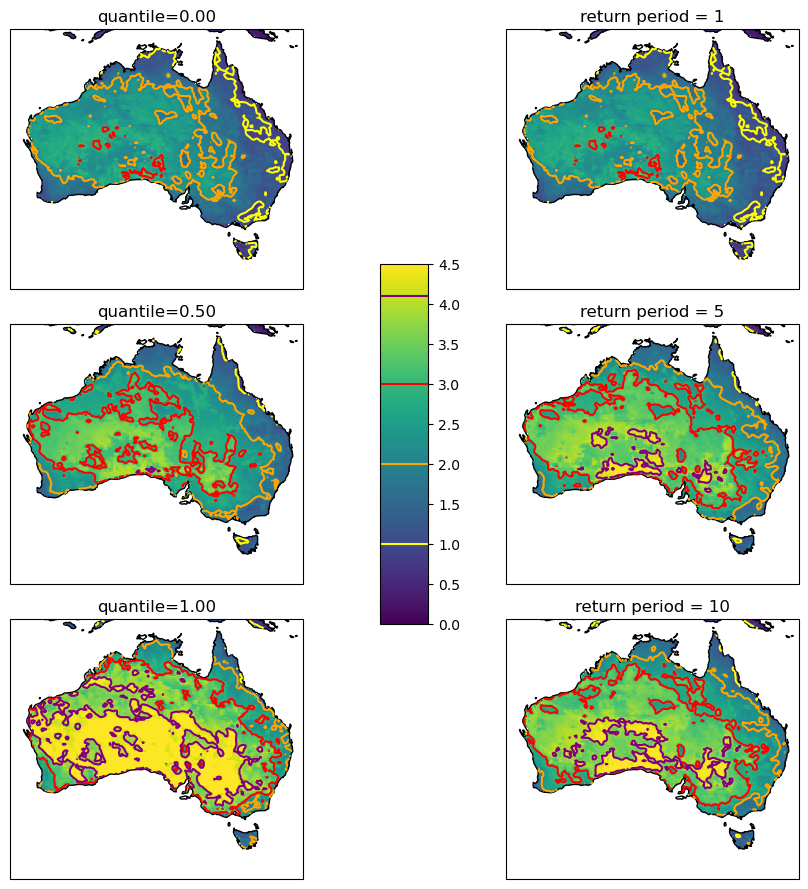

In [11]:

dowdy_1(era5_percentiles_yearly.FFDI, qs=qs_yearly)
fname = "figures/dowdy1_ffdi_yearly.png"
print("INFO: Figure saved: ",fname)
plt.savefig(fname)
dowdy_1(era5_percentiles_yearly.DWI_V,
        levels=[1,2,3,4.1],
        colors=['yellow','orange','red','purple'],
        vmin=0,vmax=4.5,
        qs = qs_yearly,
       )
fname = "figures/dowdy1_dwi_yearly.png"
print("INFO: Figure saved: ",fname)
plt.savefig(fname)

# Check Black Summer FFDI

In [22]:
#ds_2021=ds_yearly.isel({'time':-2})
#ds_2020=ds_yearly.isel({'time':-3})

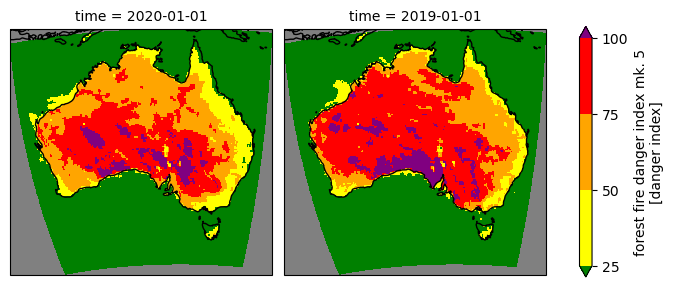

In [21]:

plotting.plot_ffdi(ds_yearly.FFDI,itimes=[-2,-3])
plt.show()

# Look at seasonal trends?

In [8]:
pct_90 = era5_percentiles.sel(quantile=.9)
era5_is_over_90 = ds.FFDI > pct_90.FFDI
era5_days_over_90 = era5_is_over_90.resample(time='QS-DEC').sum()

In [9]:
era5_days_over_90.shape

(269, 157, 177)

In [17]:
quarterly_days_over_90 = era5_days_over_90.mean(dim=['latitude','longitude'])

Text(0, 0.5, 'mean over 90pct')

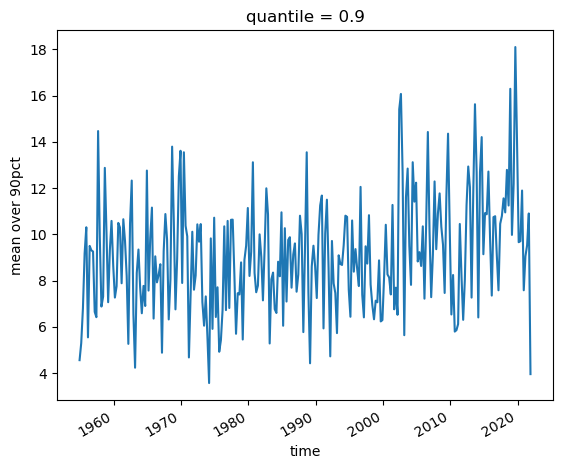

In [18]:
quarterly_days_over_90.plot()
plt.ylabel('mean over 90pct')


(744, 157, 177)
(6, 157, 177)


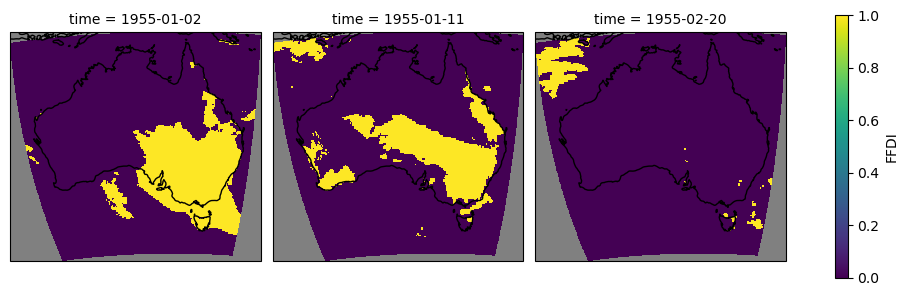

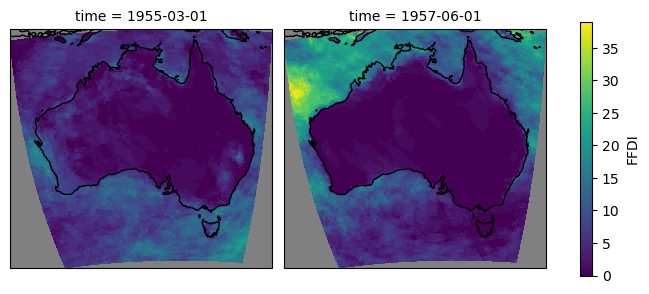

In [52]:

print(ds_daily.FFDI.shape)
print(era5_percentiles.FFDI.shape)
plotting.plot_quick(era5_is_over_90, itimes=[1,10,50]) # check sensible
plotting.plot_quick(era5_days_over_90, itimes=[1,2]) # check sensible